In [1]:
# In this notebook, several plots showing temperature change following 4xCO2 will be produced
# By: Tyler Janoski
# updated 02.24.2020

In [3]:
# Import libraries

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# create function for taking spatial averages
def spatial_mean(ds_in, lat_bound_s = -91, lat_bound_n = 91):
    """
    Use xarray/numpy to calculate spatial average while weighting for latitude.
    
    Keyword arguments:
    ds_in -- Dataset or DataArray to take the average of
    lat_bound_s -- float, Southern boundary of area to average
    lat_bound_n -- float, Northern boundary of area to average
    """
    zonal = ds_in.mean(dim='lon').sel(lat=slice(lat_bound_s,lat_bound_n))
    weights = np.cos(np.deg2rad(zonal.lat)) / np.sum(np.cos(np.deg2rad(zonal.lat)))
    return((zonal * weights).sum(dim='lat'))

In [5]:
# create function for reading in WACCM output
def read_in(case,exp,mon,ens,var):
    """
    Use xarray to read in a netCDF file.

    Keyword arguments:
    case -- output case prefix (b40.1850, f1850)
    exp -- CO2 scenario
    mon -- starting month in which CO2 is altered
    ens -- ensemble number
    var -- model output variable
    """
    filein = '/dx05/tylerj/d10/Arctic_Research/WACCM/output/'+case+'.scwc.'+exp+'.01.0'+str(
        f"{mon:02d}")+'.0'+str(f"{ens:02d}")+'.h1_'+var+'.nc'
    return(xr.open_dataset(filein,chunks=None))

In [6]:
# Read in piControl data, make a daily climatology
# Note: the first time step should be discarded, the second value is the FIRST daily average

ctrl = xr.concat([read_in('b40.1850','ctrl',m,e,'TREFHT').isel(time=slice(1,None)) for m in range(1,13,1)
           for e in range(1,11,1)],'run')['TREFHT']

# climatology is produced by grouping by the day of the year. NaN values are excluded
daily_clim = ctrl.groupby('time.dayofyear').mean(dim=['time','run'],skipna=True).load()

# read in abrupt4xCO2 data
TREFHT = xr.open_mfdataset('/dx05/tylerj/d10/Arctic_Research/WACCM/output/b40.1850.scwc.4xCO2.01.001.*_TREFHT.nc',
                          concat_dim='ensemble',combine='nested')['TREFHT'].isel(time=slice(1,None))

# depending on which month we read in, we need to adjust the climatology to start on a certain day of the year
# the following calculation just determines how we have to shift in order to match the starting month
roll_val = -1 * (int(TREFHT['time.dayofyear'].isel(time=0)) - 1)
rolled = daily_clim.roll(dayofyear=roll_val)

# take the difference between 4xCO2 and control climatology
diff_jan = TREFHT - np.tile(rolled,(2,1,1))

# do the same for WACCM runs starting in July (007 instead of 001)
TREFHT = xr.open_mfdataset('/dx05/tylerj/d10/Arctic_Research/WACCM/output/b40.1850.scwc.4xCO2.01.007.*_TREFHT.nc',
                          concat_dim='ensemble',combine='nested')['TREFHT'].isel(time=slice(1,None))

roll_val = -1 * (int(TREFHT['time.dayofyear'].isel(time=0)) - 1)
rolled = daily_clim.roll(dayofyear=roll_val)

diff_jul = TREFHT - np.tile(rolled,(2,1,1))

/home/tylerj/miniconda3/lib/python3.7/site-packages/xarray/core/dataarray.py:2793: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  shifts=shifts, roll_coords=roll_coords, **shifts_kwargs
/home/tylerj/miniconda3/lib/python3.7/site-packages/xarray/core/dataarray.py:2793: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  shifts=shifts, roll_coords=roll_coords, **shifts_kwargs


In [7]:
# calculate mean and spread for both global and Arctic using spatial mean function
# see spatial mean function above for further details

glb_mean_jan = spatial_mean(diff_jan).mean(dim='ensemble')
glb_std_jan = spatial_mean(diff_jan).std(dim='ensemble')
arc_mean_jan = spatial_mean(diff_jan,lat_bound_s=70).mean(dim='ensemble')
arc_std_jan = spatial_mean(diff_jan,lat_bound_s=70).std(dim='ensemble')

glb_mean_jul = spatial_mean(diff_jul).mean(dim='ensemble')
glb_std_jul = spatial_mean(diff_jul).std(dim='ensemble')
arc_mean_jul = spatial_mean(diff_jul,lat_bound_s=70).mean(dim='ensemble')
arc_std_jul = spatial_mean(diff_jul,lat_bound_s=70).std(dim='ensemble')

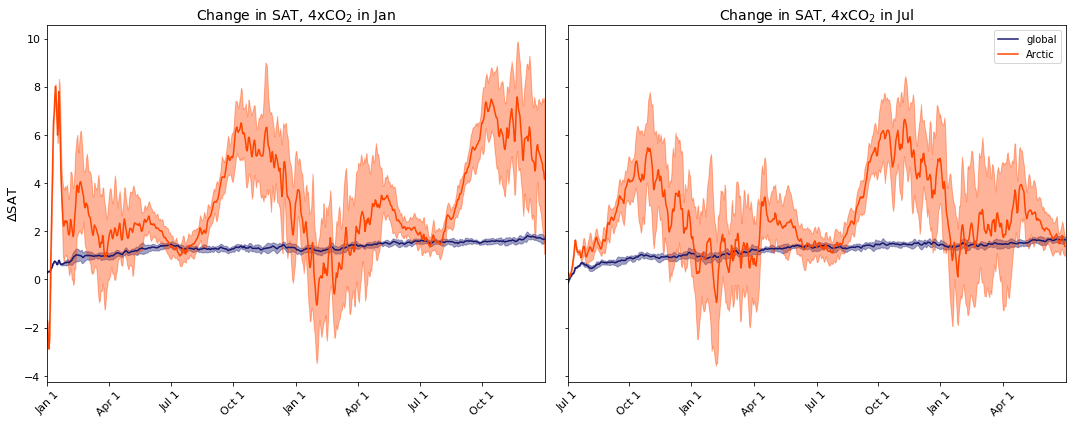

In [34]:
# create figure object
fig, ax = plt.subplots(ncols=2,figsize=(15,6),sharey=True)

xs = np.arange(0,730,1)

# Do some manipulation to be able to plot the time axis as the first of each month
first_days = np.array(glb_mean_jan.isel(time=slice(None,365)).where(glb_mean_jan
                                                   ['time.day'] == 2).dropna(dim='time')['time.dayofyear']-2)
x_vals = np.concatenate((first_days,first_days+365))[::3]
x_labs = np.tile(['Jan 1','Feb 1','Mar 1','Apr 1','May 1','Jun 1','Jul 1','Aug 1','Sep 1','Oct 1','Nov 1','Dec 1'],
                 (2))[::3]

# do the same for july
xs_jul = xs+181
x_vals_jul = np.concatenate((first_days+181,first_days+181+365))[::3]
x_labs_jul = np.tile(['Jul 1','Aug 1','Sep 1','Oct 1','Nov 1','Dec 1',
                      'Jan 1','Feb 1','Mar 1','Apr 1','May 1','Jun 1'],(2))[::3]

# plot 4xCO2 starting in Jan
ax[0].plot(xs, glb_mean_jan, color='midnightblue')
ax[0].fill_between(xs, glb_mean_jan-glb_std_jan, glb_mean_jan+glb_std_jan,color='midnightblue',alpha=0.4)
ax[0].plot(xs, arc_mean_jan, color='orangered')
ax[0].fill_between(xs, arc_mean_jan-arc_std_jan, arc_mean_jan+arc_std_jan,color='orangered',alpha=0.4)
ax[0].set_xlim([0,730])
ax[0].set_xticks(x_vals)
ax[0].set_xticklabels(x_labs)
ax[0].tick_params(axis='x', rotation=45,labelsize=11)
ax[0].tick_params(axis='y',labelsize=11)
ax[0].set_ylabel(r'$\Delta$SAT',fontsize=13)
ax[0].set_title(r'Change in SAT, 4xCO$_2$ in Jan',fontsize=14)

# plot 4xCO2 starting in July
ax[1].plot(xs_jul, glb_mean_jul, color='midnightblue',label='global')
ax[1].fill_between(xs_jul, glb_mean_jul-glb_std_jul, glb_mean_jul+glb_std_jul,color='midnightblue',alpha=0.4)
ax[1].plot(xs_jul, arc_mean_jul, color='orangered',label='Arctic')
ax[1].fill_between(xs_jul, arc_mean_jul-arc_std_jul, arc_mean_jul+arc_std_jul,color='orangered',alpha=0.4)
ax[1].set_xlim([181,181+730])
ax[1].set_xticks(x_vals_jul)
ax[1].set_xticklabels(x_labs_jul)
ax[1].tick_params(axis='x', rotation=45,labelsize=11)
ax[1].tick_params(axis='y',labelsize=11)
ax[1].legend(loc='best')
ax[1].set_title(r'Change in SAT, 4xCO$_2$ in Jul',fontsize=14)

plt.tight_layout()
plt.show()